<a href="https://colab.research.google.com/github/Kambey-san/FDMLM/blob/Lesson_02/FDMLM_KAA_HW_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование и диагностика в медицине с помощью машинного обучения
Урок 2./ ДЗ

https://archive.ics.uci.edu/dataset/206/relative+location+of+ct+slices+on+axial+axis

C этим датасетом будем работать на уроке.

ДЗ - на этом же датасете выполнить задачу классификации.

Или же ДЗ опционально выполнить классификацию https://archive.ics.uci.edu/dataset/174/parkinsons

Работаем с датасетом **Oxford Parkinson's Disease Detection Dataset**

Этот набор данных состоит из ряда биомедицинских голосовых измерений 31 человека, 23 из которых страдают болезнью Паркинсона (БП). Каждый столбец в таблице представляет собой определенное голосовое измерение, а каждая строка соответствует одной из 195 голосовых записей этих людей (столбец «имя»). Основная цель данных — отличить здоровых людей от людей с БП в соответствии со столбцом «статус», который установлен на 0 для здоровых и 1 для БП.

In [1]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.8 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
                        recall_score, f1_score, log_loss, confusion_matrix, \
                  classification_report, roc_curve, auc, precision_recall_curve

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, \
                       LabelEncoder, label_binarize

from typing import List, Optional, Tuple, Union

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def get_metrics(y_test, y_pred, y_score, name, rnd_state=1234):
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    # Основные метрики для задачи классификации
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score[:, 1])
    df_metrics['Precision'] = precision_score(y_test, y_pred)
    df_metrics['Recall'] = recall_score(y_test, y_pred)
    df_metrics['f1'] = f1_score(y_test, y_pred)
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

In [5]:
# Загрузка данных
!pip install ucimlrepo

In [6]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
parkinsons = fetch_ucirepo(id=174)

# data (as pandas dataframes)
X = parkinsons.data.features
y = parkinsons.data.targets

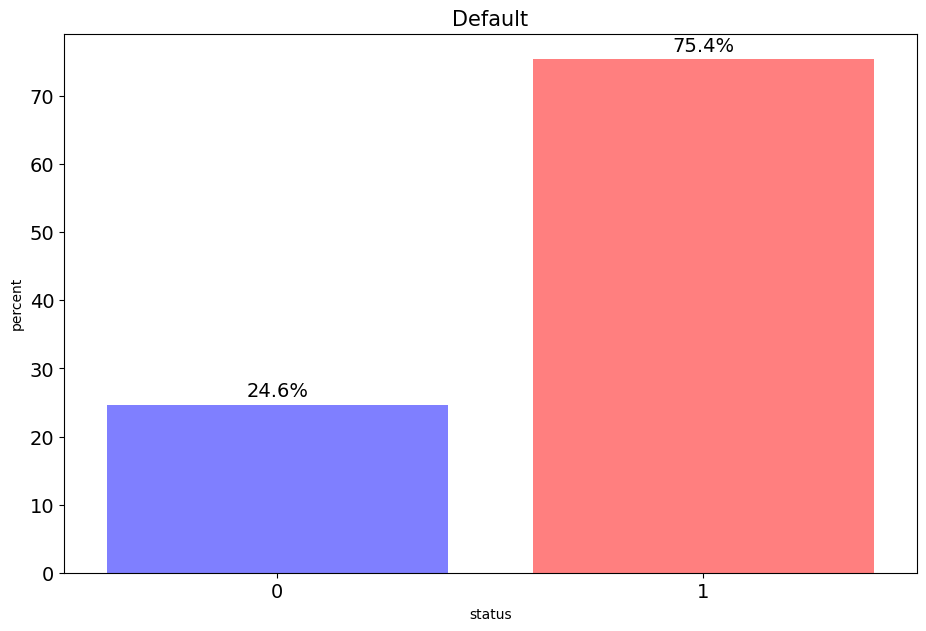

In [8]:
# определение целевой переменной
norm_target = y['status'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
norm_target.columns = ['status', 'percent']

plt.figure(figsize=(11, 7))
ax = sns.barplot(x='status', y='percent', data=norm_target, alpha=0.5)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(
        percentage,
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=14)

colors = ['b', 'r']
for i, p in enumerate(ax.patches):
    p.set_facecolor(colors[i % len(colors)])

plt.title('Default', fontsize=15)
plt.xlabel('status', fontsize=10)
plt.ylabel('percent', fontsize=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Вывод:** имеет место дисбаланс классов

In [10]:
# размерность
X.shape

(195, 22)

In [15]:
# общая информация
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MDVP:Fo       195 non-null    float64
 1   MDVP:Fhi      195 non-null    float64
 2   MDVP:Flo      195 non-null    float64
 3   MDVP:Jitter   195 non-null    float64
 4   MDVP:Jitter   195 non-null    float64
 5   MDVP:RAP      195 non-null    float64
 6   MDVP:PPQ      195 non-null    float64
 7   Jitter:DDP    195 non-null    float64
 8   MDVP:Shimmer  195 non-null    float64
 9   MDVP:Shimmer  195 non-null    float64
 10  Shimmer:APQ3  195 non-null    float64
 11  Shimmer:APQ5  195 non-null    float64
 12  MDVP:APQ      195 non-null    float64
 13  Shimmer:DDA   195 non-null    float64
 14  NHR           195 non-null    float64
 15  HNR           195 non-null    float64
 16  RPDE          195 non-null    float64
 17  DFA           195 non-null    float64
 18  spread1       195 non-null    

In [14]:
# примеры признаков
X.sample(10)

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP:Jitter,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer,...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
125,145.174,198.109,80.637,0.00733,0.00733,0.00414,0.00422,0.01242,0.02362,0.02362,...,0.01944,0.03706,0.01874,18.857,0.637518,0.735546,-5.594275,0.127950,1.765957,0.222716
133,118.747,123.723,109.836,0.00331,0.00331,0.00168,0.00171,0.00504,0.01043,0.01043,...,0.00903,0.01471,0.00504,25.619,0.482296,0.723096,-6.448134,0.178713,2.034827,0.141422
157,117.963,134.209,100.757,0.01813,0.01813,0.01117,0.00718,0.03351,0.04912,0.04912,...,0.02916,0.07830,0.10748,19.075,0.630547,0.646786,-3.444478,0.303214,2.964568,0.261305
97,125.036,143.946,116.187,0.01280,0.01280,0.00743,0.00623,0.02228,0.03886,0.03886,...,0.03088,0.06406,0.08151,15.338,0.629574,0.714485,-4.020042,0.265315,2.671825,0.340623
83,98.804,102.305,87.804,0.00432,0.00432,0.00247,0.00258,0.00742,0.02223,0.02223,...,0.01552,0.03831,0.00882,22.244,0.576644,0.772416,-6.025367,0.078202,2.053601,0.177275
163,112.150,131.669,97.527,0.00519,0.00519,0.00291,0.00284,0.00873,0.01756,0.01756,...,0.01363,0.02902,0.01435,21.219,0.557045,0.673086,-5.617124,0.184896,1.871871,0.212386
25,104.400,206.002,77.968,0.00633,0.00633,0.00316,0.00375,0.00948,0.03767,0.03767,...,0.03780,0.05197,0.02887,22.066,0.522746,0.737948,-5.571843,0.236853,2.846369,0.219514
132,119.056,125.213,86.795,0.00346,0.00346,0.00169,0.00170,0.00508,0.01201,0.01201,...,0.00915,0.01898,0.00903,23.389,0.470972,0.721308,-5.436135,0.254909,2.516320,0.232209
170,244.990,272.210,239.170,0.00451,0.00451,0.00279,0.00237,0.00837,0.01897,0.01897,...,0.01255,0.03253,0.01049,21.528,0.522812,0.646818,-7.304500,0.171088,2.095237,0.096220
154,119.100,128.442,88.833,0.00692,0.00692,0.00393,0.00300,0.01179,0.02682,0.02682,...,0.02018,0.04451,0.04611,21.824,0.651680,0.659333,-4.239028,0.175691,2.451130,0.247455


In [16]:
# пропуски
X.isna().any().any()

False

In [17]:
# дубли
X.duplicated().any()

False

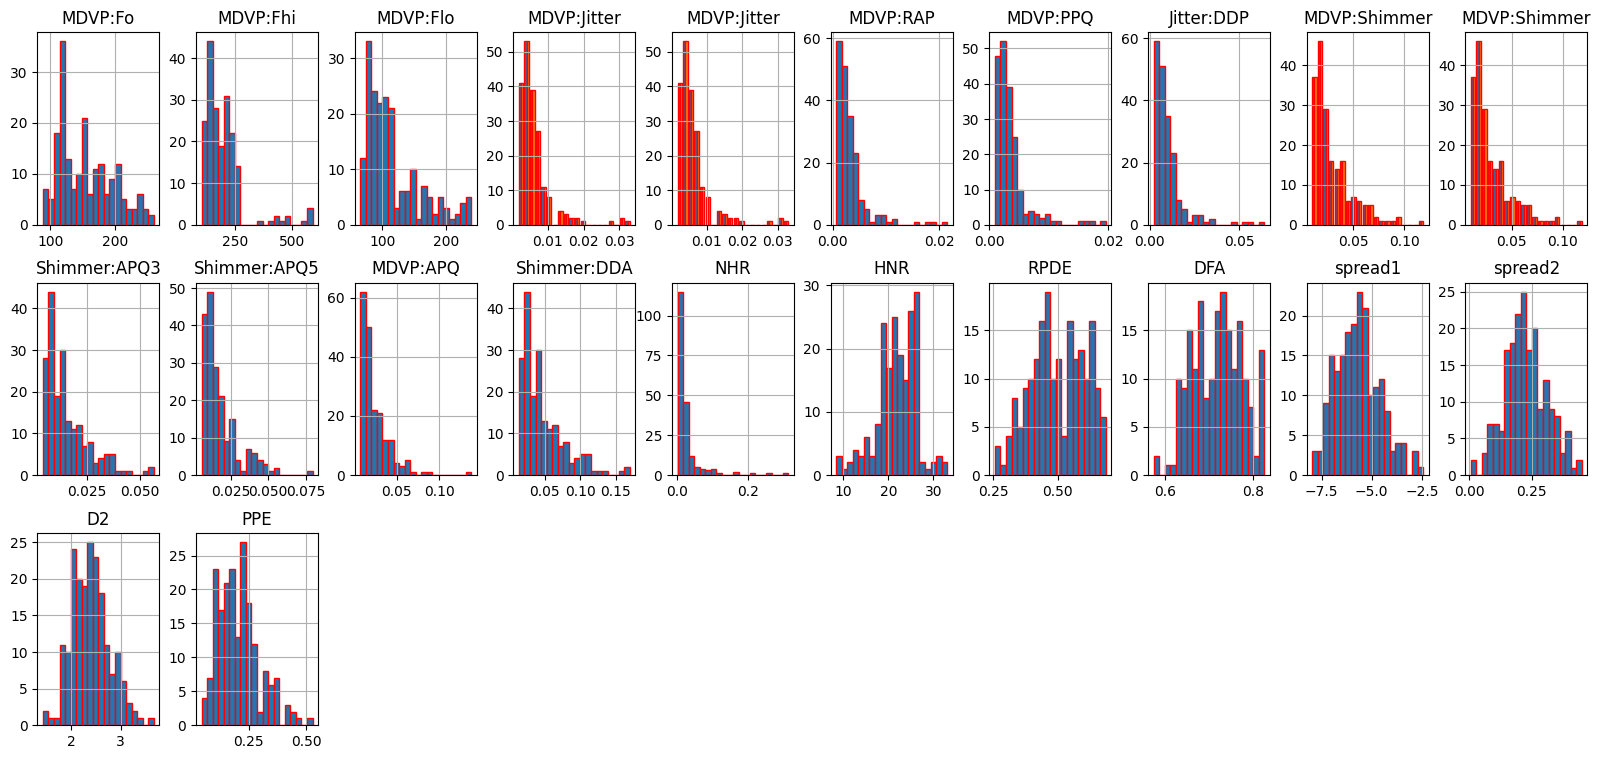

In [19]:
# Распределения признаков
X.hist(figsize=(20,9), layout=(-1,10), bins=20, edgecolor='r');

**Вывод:** бинарные признаки отсутствуют

In [20]:
# Числовые характеристики распределения
X.describe()

,MDVP:Fo,MDVP:Fhi,MDVP:Flo,MDVP:Jitter,MDVP:Jitter,MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer,...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.006220,0.003306,0.003446,0.009920,0.029709,0.029709,...,0.024081,0.046993,0.024847,21.885974,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.004848,0.002968,0.002759,0.008903,0.018857,0.018857,...,0.016947,0.030459,0.040418,4.425764,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.001680,0.000680,0.000920,0.002040,0.009540,0.009540,...,0.007190,0.013640,0.000650,8.441000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.003460,0.001660,0.001860,0.004985,0.016505,0.016505,...,0.013080,0.024735,0.005925,19.198000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.004940,0.002500,0.002690,0.007490,0.022970,0.022970,...,0.018260,0.038360,0.011660,22.085000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.007365,0.003835,0.003955,0.011505,0.037885,0.037885,...,0.029400,0.060795,0.025640,25.075500,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.033160,0.021440,0.019580,0.064330,0.119080,0.119080,...,0.137780,0.169420,0.314820,33.047000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


<Axes: >

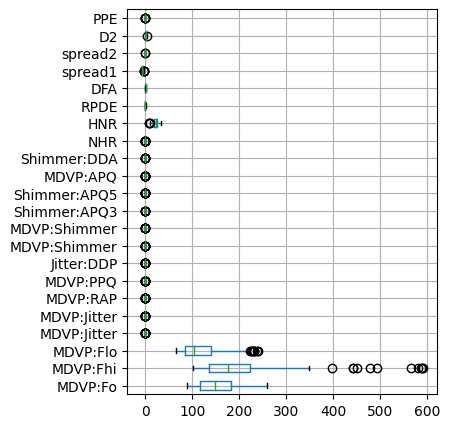

In [21]:
# выбросы
X.boxplot(vert=False, figsize=(4, 5))

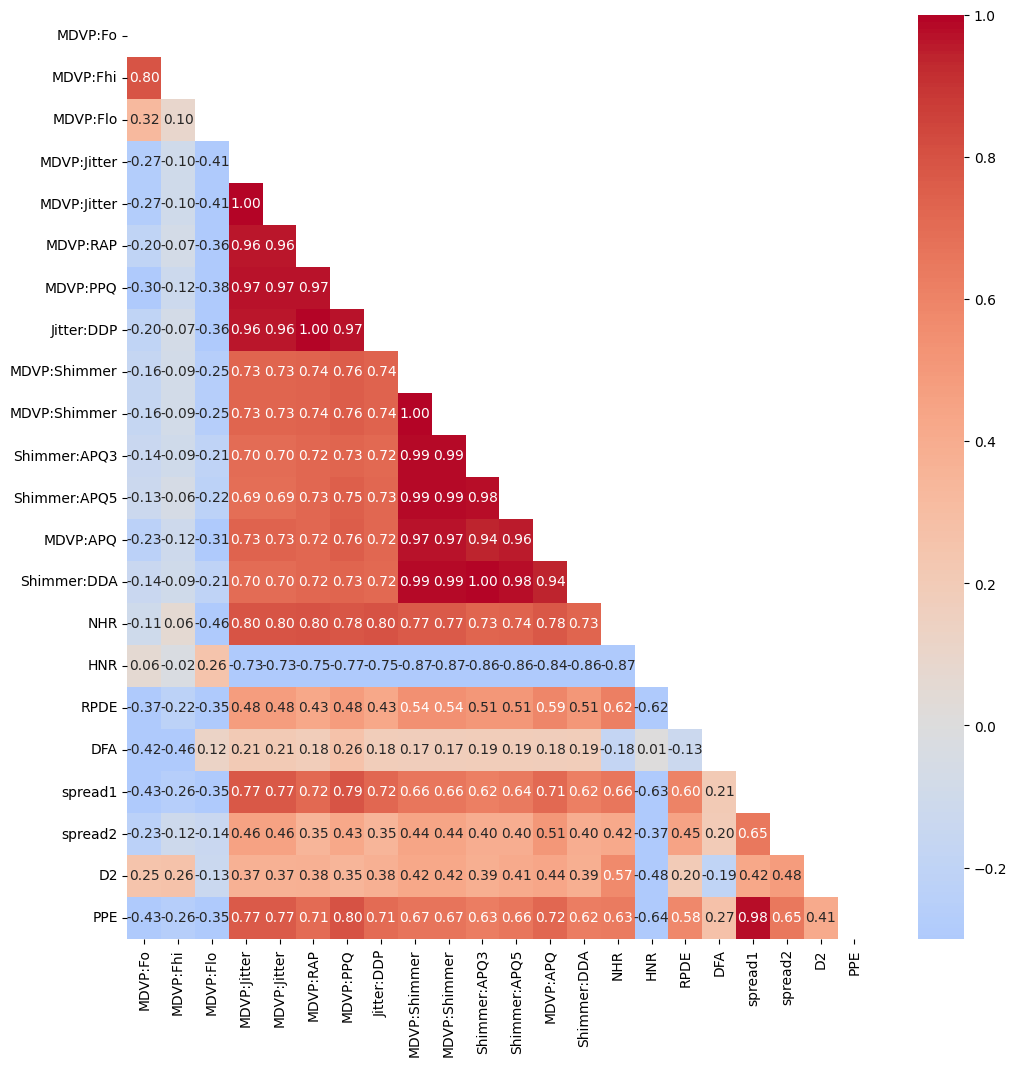

In [22]:
# матрица корреляции
matrix = np.triu(X.corr(method='spearman'))

plt.figure(figsize=(12, 12))

sns.heatmap(X.corr(method='spearman'), annot=True,
            fmt='.2f', vmin=-0.3, center=0, cmap='coolwarm', mask=matrix);

**Вывод:** необходимо удалить признаки с корреляцией >= 0,8

In [23]:
corr_df = X.corr()

mask = np.triu(np.ones_like(corr_df, dtype=bool) & (corr_df >= .8))
tri_df = corr_df.mask(mask)

to_drop = [c for c in tri_df.columns if any(tri_df[c] >= .8)]

reduced_X = X.drop(to_drop, axis=1)

In [24]:
# размерность после редукции
reduced_X.shape

(195, 11)

## Models

In [26]:
rnd_state=1234

In [30]:
# y = y['status']

# разбиение на обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(reduced_X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=rnd_state,
                                                    shuffle=True,
                                                    # stratify=y
                                                    )

In [32]:
# Логистическая регрессия
pipe_lr_base = Pipeline([('scaler', StandardScaler()),
                         ('clf', LogisticRegression(random_state=rnd_state,
                                            max_iter=10000,
                                            # class_weight='balanced'
                                            ))])

pipe_lr_base.fit(X_train, y_train)

y_pred = pipe_lr_base.predict(X_test)
y_score = pipe_lr_base.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.88      0.94      0.91        32

    accuracy                           0.85        39
   macro avg       0.74      0.68      0.70        39
weighted avg       0.83      0.85      0.84        39



In [33]:
metrics = get_metrics(y_test, y_pred, y_score, name='Log_Reg_Baseline')
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Log_Reg_Baseline,0.846154,0.816964,0.882353,0.9375,0.909091,0.346451


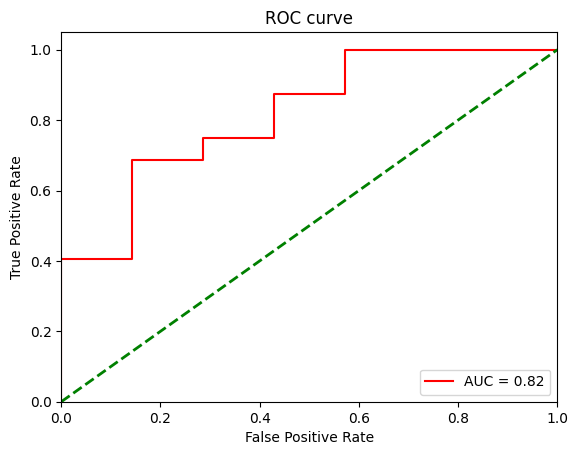

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='red', label=f'AUC = {round(roc_auc,2)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

**Вывод:** AUC = 0,82 - модель работает удовлетворительно

In [42]:
# если отбалансировать веса:
pipe_lr_base = Pipeline([('scaler', StandardScaler()),
                         ('clf', LogisticRegression(random_state=rnd_state,
                                            max_iter=10000,
                                            class_weight='balanced'
                                            ))])

pipe_lr_base.fit(X_train, y_train)

y_pred = pipe_lr_base.predict(X_test)
y_score = pipe_lr_base.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.57      0.50         7
           1       0.90      0.84      0.87        32

    accuracy                           0.79        39
   macro avg       0.67      0.71      0.69        39
weighted avg       0.82      0.79      0.80        39



In [43]:

metrics = pd.concat(
    [metrics,
     get_metrics(y_test, y_pred, y_score, name='Log_Reg_ClassWeight')])

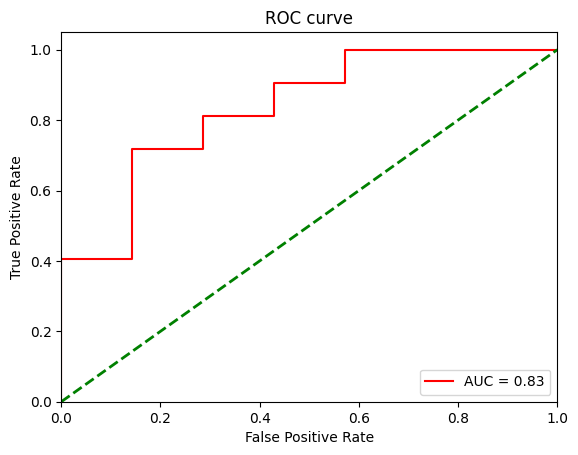

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='red', label=f'AUC = {round(roc_auc,2)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

**Вывод:** AUC = 0,83 - улучшения незначительные

In [45]:
# данные несбалансированы => попробуем Random oversampling
from imblearn.over_sampling import RandomOverSampler

In [46]:
oversample = RandomOverSampler(sampling_strategy=1.0)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [47]:
X_train.shape

(156, 11)

In [48]:
X_over.shape

(230, 11)

In [49]:
y_train.value_counts()

,count
status,
1,115
0,41


In [50]:
y_over.value_counts()

,count
status,
1,115
0,115


In [52]:
pipe_lr_base = Pipeline([('scaler', StandardScaler()),
                         ('clf', LogisticRegression(random_state=rnd_state,
                                                    max_iter=10000,
                                            ))])

pipe_lr_base.fit(X_over, y_over)

y_pred = pipe_lr_base.predict(X_test)
y_score = pipe_lr_base.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.57      0.47         7
           1       0.90      0.81      0.85        32

    accuracy                           0.77        39
   macro avg       0.65      0.69      0.66        39
weighted avg       0.81      0.77      0.78        39



In [53]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test, y_pred, y_score, name='Log_Reg_OverSampling')])

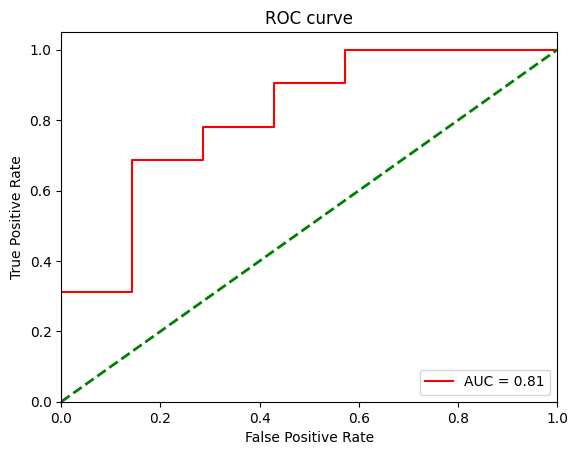

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='red', label=f'AUC = {round(roc_auc,2)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

**Вывод:** AUC = 0,81 - пока наихудший результат

In [56]:
# Случайное удаление данных (Random Undersampling)
from imblearn.under_sampling import RandomUnderSampler

In [57]:
undersample = RandomUnderSampler(sampling_strategy=1.0)
X_under, y_under = undersample.fit_resample(X_train, y_train)

In [58]:
X_under.shape

(82, 11)

In [59]:
X_train.shape

(156, 11)

In [60]:
y_under.value_counts()

,count
status,
0,41
1,41


In [62]:
pipe_lr_base = Pipeline([('scaler', StandardScaler()),
                         ('clf', LogisticRegression(random_state=rnd_state,
                                                    max_iter=10000,
                                            ))])

pipe_lr_base.fit(X_under, y_under)

y_pred = pipe_lr_base.predict(X_test)
y_score = pipe_lr_base.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.71      0.59         7
           1       0.93      0.84      0.89        32

    accuracy                           0.82        39
   macro avg       0.72      0.78      0.74        39
weighted avg       0.85      0.82      0.83        39



In [63]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test, y_pred, y_score, name='Log_Reg_UnderSampling')])

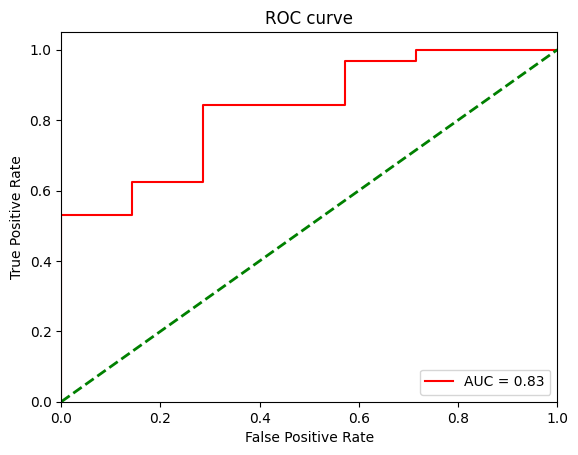

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='red', label=f'AUC = {round(roc_auc,2)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

**Вывод:** AUC = 0,83 - как в случае с логистической регрессией после балансировки весов, кардинально улучшить не удалось

In [65]:
# передискретизация со SMOTE
from imblearn.over_sampling import SMOTE

In [66]:
smote = SMOTE(k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [67]:
y_train.value_counts()

,count
status,
1,115
0,41


In [68]:
y_smote.value_counts()

,count
status,
1,115
0,115


In [69]:
pipe_lr_base = Pipeline([('scaler', StandardScaler()),
                         ('clf', LogisticRegression(random_state=rnd_state,
                                                    max_iter=10000,
                                            ))])

pipe_lr_base.fit(X_smote, y_smote)

y_pred = pipe_lr_base.predict(X_test)
y_score = pipe_lr_base.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.57      0.47         7
           1       0.90      0.81      0.85        32

    accuracy                           0.77        39
   macro avg       0.65      0.69      0.66        39
weighted avg       0.81      0.77      0.78        39



In [70]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test, y_pred, y_score, name='Log_Reg_SMOTE')])

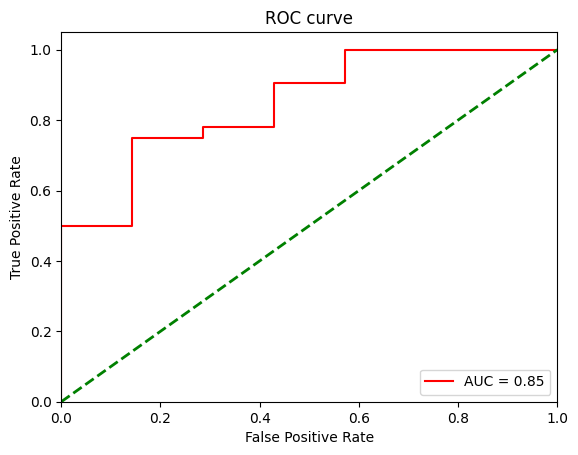

In [72]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='red', label=f'AUC = {round(roc_auc,2)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

**Вывод:** AUC = 0,85 - приближаемся к заветному показателю 0,9

In [73]:
# CatBoost
pipe_catboost = Pipeline([('scaler', StandardScaler()),
                         ('clf', CatBoostClassifier(random_state=rnd_state,
                                            # auto_class_weights='Balanced',
                                            verbose=False))])

pipe_catboost.fit(X_train, y_train)

y_pred = pipe_catboost.predict(X_test)
y_score = pipe_catboost.predict_proba(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.94      0.97      0.95        32

    accuracy                           0.92        39
   macro avg       0.89      0.84      0.86        39
weighted avg       0.92      0.92      0.92        39



In [74]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test, y_pred, y_score, name='Catboost_ClassWeight')])

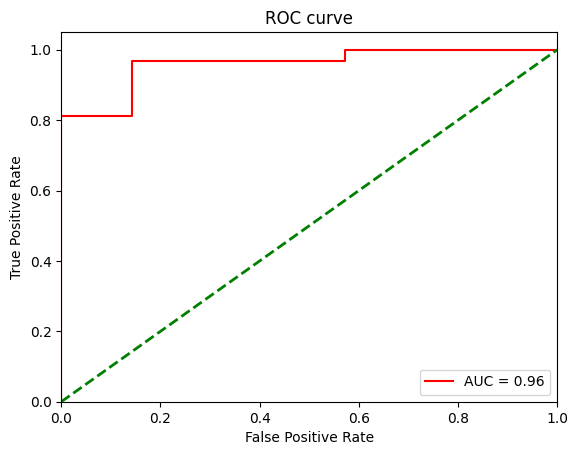

In [75]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='red', label=f'AUC = {round(roc_auc,2)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

**Вывод:** AUC = 0,96 - удалось существенно улучшить модель по сравнению с логистической регрессией

In [76]:
# попробуем многослойный перцептрон MLP Classifier
pipe_mlp = Pipeline([('scaler', StandardScaler()),
                     ('clf', MLPClassifier(random_state=rnd_state,
                                           solver='adam',
                                           verbose=False))])

pipe_mlp.fit(X_train, y_train)

y_pred = pipe_mlp.predict(X_test)
y_score = pipe_mlp.predict_proba(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.94      0.94      0.94        32

    accuracy                           0.90        39
   macro avg       0.83      0.83      0.83        39
weighted avg       0.90      0.90      0.90        39



In [77]:
metrics = pd.concat(
    [metrics,
     get_metrics(y_test, y_pred, y_score, name='MLP_Baseline')])

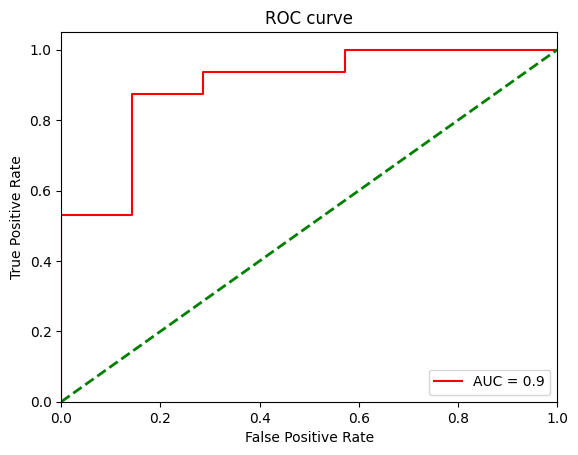

In [78]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='red', label=f'AUC = {round(roc_auc,2)}')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.legend(loc="lower right")
plt.show()

**Вывод:** AUC = 0,9 - модель норм, но хуже, чем с использованием *CatBoost*

## Обобщение результатов

In [79]:
metrics.set_index('model', inplace=True)
sorted_metrics = metrics.sort_values(by='ROC_AUC', ascending=False)
round(sorted_metrics, 5)

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
Catboost_ClassWeight,0.92308,0.95982,0.93939,0.96875,0.95385,0.19844
MLP_Baseline,0.89744,0.89732,0.93750,0.93750,0.93750,0.28270
Log_Reg_SMOTE,0.76923,0.84821,0.89655,0.81250,0.85246,0.40101
Log_Reg_ClassWeight,0.79487,0.83482,0.90000,0.84375,0.87097,0.40225
Log_Reg_UnderSampling,0.82051,0.83036,0.93103,0.84375,0.88525,0.41306
Log_Reg_Baseline,0.84615,0.81696,0.88235,0.93750,0.90909,0.34645
Log_Reg_ClassWeight,0.84615,0.81696,0.88235,0.93750,0.90909,0.34645
Log_Reg_OverSampling,0.76923,0.81250,0.89655,0.81250,0.85246,0.42809


**Вывод:** верятно из-за небольшого количества объектов, MLP Classifier показал невыдающиеся результаты. Логистическая регрессия при таком дисбалансе классов, не смотря на балансировку, не подходит для анализа датасета, хотя результаты можно признать удовлетворительными. Лучще всего показала себя модель с применением метода CatBoost  